In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import joblib

# 1. Setup & Database Connection

In [26]:
import pandas as pd
import pyodbc
from sqlalchemy import create_engine

# Update with your SQL Server details
server = r"DESKTOP-LGO4HD4\MSSQL"   # Your server name
database = "db_customer_churn"      # Your database name

# Create connection string
engine = create_engine(
    f"mssql+pyodbc://@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes",
    fast_executemany=True
)
pd.set_option('display.max_columns', None)
# Test connection: load a small sample
df_raw = pd.read_sql("SELECT TOP 10 * FROM raw_Churn;", engine)
df_raw.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,Internet_Type,Online_Security,Online_Backup,Device_Protection_Plan,Premium_Support,Streaming_TV,Streaming_Movies,Streaming_Music,Unlimited_Data,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,11098-MAD,Female,30,Yes,Madhya Pradesh,0,31,Deal 1,Yes,No,Yes,Fiber Optic,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Two Year,No,Bank Withdrawal,95.099998,6683.399902,0.00,0,631.719971,7315.120117,Stayed,None,None
1,11114-PUN,Male,51,No,Punjab,5,9,Deal 5,Yes,No,Yes,DSL,No,No,Yes,No,No,No,No,No,Month-to-Month,Yes,Bank Withdrawal,49.150002,169.050003,0.00,10,122.370003,301.420013,Churned,Competitor,Competitor had better devices
2,11167-WES,Female,43,Yes,West Bengal,3,28,Deal 1,Yes,Yes,Yes,Fiber Optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Two Year,Yes,Bank Withdrawal,116.050003,8297.500000,42.57,110,1872.979980,10237.910156,Stayed,None,None
3,11179-MAH,Male,35,No,Maharashtra,10,12,None,Yes,No,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,84.400002,5969.299805,0.00,0,219.389999,6188.689941,Stayed,None,None
4,11180-TAM,Male,75,Yes,Tamil Nadu,12,27,Deal 2,Yes,No,Yes,DSL,Yes,No,No,Yes,Yes,Yes,No,No,Two Year,Yes,Credit Card,72.599998,4084.350098,0.00,140,332.079987,4556.430176,Stayed,None,None


# 2. Data Exploration with SQL

In [2]:
# Gender distribution
sql_gender = """
SELECT Gender, 
       COUNT(*) AS TotalCount,
       COUNT(*) * 100.0 / (SELECT COUNT(*) FROM raw_Churn) AS Percentage
FROM raw_Churn
GROUP BY Gender;
"""
df_gender = pd.read_sql(sql_gender, engine)

# Contract type distribution
sql_contract = """
SELECT Contract, 
       COUNT(*) AS TotalCount,
       COUNT(*) * 100.0 / (SELECT COUNT(*) FROM raw_Churn) AS Percentage
FROM raw_Churn
GROUP BY Contract;
"""
df_contract = pd.read_sql(sql_contract, engine)

# Revenue by Customer Status
sql_revenue = """
SELECT Customer_Status, 
       COUNT(*) AS TotalCount,
       SUM(Total_Revenue) AS TotalRevenue,
       SUM(Total_Revenue) * 100.0 / (SELECT SUM(Total_Revenue) FROM raw_Churn) AS RevPercentage
FROM raw_Churn
GROUP BY Customer_Status;
"""
df_revenue = pd.read_sql(sql_revenue, engine)

display(df_gender, df_contract, df_revenue)

,Gender,TotalCount,Percentage
0,Male,2370,36.927392
1,Female,4048,63.072608


,Contract,TotalCount,Percentage
0,Month-to-Month,3286,51.199751
1,One Year,1413,22.016204
2,Two Year,1719,26.784045


,Customer_Status,TotalCount,TotalRevenue,RevPercentage
0,Joined,411,4.928156e+04,0.253097
1,Churned,1732,3.411961e+06,17.522943
2,Stayed,4275,1.601015e+07,82.223960


## 2.1 Load Full Raw Data from SQL

In [3]:
df_raw = pd.read_sql("SELECT * FROM raw_Churn;", engine)

## 2.2 Quick Null Value Check in Pandas

In [7]:
 df_raw.isnull().sum()

Customer_ID                       0
Gender                            0
Age                               0
Married                           0
State                             0
Number_of_Referrals               0
Tenure_in_Months                  0
Value_Deal                     3548
Phone_Service                     0
Multiple_Lines                  622
Internet_Service                  0
Internet_Type                  1390
Online_Security                1390
Online_Backup                  1390
Device_Protection_Plan         1390
Premium_Support                1390
Streaming_TV                   1390
Streaming_Movies               1390
Streaming_Music                1390
Unlimited_Data                 1390
Contract                          0
Paperless_Billing                 0
Payment_Method                    0
Monthly_Charge                    0
Total_Charges                     0
Total_Refunds                     0
Total_Extra_Data_Charges          0
Total_Long_Distance_Charges 

Columns with some NULLs:
- Value_Deal → 3548 NULLs (more than half of the customers didn’t select any deal)
- Multiple_Lines → 622 NULLs
- Internet_Type, Online_Security, Online_Backup, Device_Protection_Plan, Premium_Support, Streaming_TV, Streaming_Movies, Streaming_Music, Unlimited_Data → 1390 NULLs each
These need replacement with 'No' or 'None' for consistent analysis.

Columns with many NULLs:
- Churn_Category → 4686 NULLs
- Churn_Reason → 4686 NULLs
Most customers didn’t churn, so these fields are empty — replace with 'Others' to maintain consistency.

# 3. Data Cleaning & Production Table in SQL

### Step 1: Create prod_Churn table (cleaned with null handling + duplicate removal)

In [14]:
from sqlalchemy import text

sql_create_prod = text("""
-- Insert cleaned data into prod_Churn
SELECT DISTINCT
    Customer_ID,
    Gender,
    Age,
    Married,
    State,
    Number_of_Referrals,
    Tenure_in_Months,
    ISNULL(Value_Deal, 'None') AS Value_Deal,
    Phone_Service,
    ISNULL(Multiple_Lines, 'No') AS Multiple_Lines,
    Internet_Service,
    ISNULL(Internet_Type, 'None') AS Internet_Type,
    ISNULL(Online_Security, 'No') AS Online_Security,
    ISNULL(Online_Backup, 'No') AS Online_Backup,
    ISNULL(Device_Protection_Plan, 'No') AS Device_Protection_Plan,
    ISNULL(Premium_Support, 'No') AS Premium_Support,
    ISNULL(Streaming_TV, 'No') AS Streaming_TV,
    ISNULL(Streaming_Movies, 'No') AS Streaming_Movies,
    ISNULL(Streaming_Music, 'No') AS Streaming_Music,
    ISNULL(Unlimited_Data, 'No') AS Unlimited_Data,
    Contract,
    Paperless_Billing,
    Payment_Method,
    Monthly_Charge,
    Total_Charges,
    Total_Refunds,
    Total_Extra_Data_Charges,
    Total_Long_Distance_Charges,
    Total_Revenue,
    Customer_Status,
    ISNULL(Churn_Category, 'Others') AS Churn_Category,
    ISNULL(Churn_Reason, 'Others') AS Churn_Reason
INTO dbo.prod_Churn
FROM dbo.raw_Churn;
""")

with engine.begin() as conn:
    conn.execute(sql_create_prod)

print("prod_Churn table created successfully")


prod_Churn table created successfully


## 4. Create Views for Analysis

In [17]:
# 1. Create ChurnData view (only Churned & Stayed)
# 2. Create JoinData view (only Joined customers)

sql_view_churn   = text("""
CREATE VIEW dbo.vw_ChurnData AS
SELECT * 
FROM dbo.prod_Churn
WHERE Customer_Status IN ('Churned', 'Stayed');
""")

sql_view_join = text("""
CREATE VIEW dbo.vw_JoinData AS
SELECT *
FROM dbo.prod_Churn
WHERE Customer_Status = 'Joined';
""")
with engine.begin() as conn:
    conn.execute(sql_view_churn)
    conn.execute(sql_view_join)
print ("views vw_ChurnData & vw_JoinData created")

views vw_ChurnData & vw_JoinData created


We can now move to Power BI to perform in-depth Churn Analysis
In Power BI, we’ll visualize key metrics such as:
- Churn distribution by gender, contract, and tenure  
- Churn category and reason analysis  
- Churn rate trends by tenure and state  

This stage helps us identify why customers are leaving and uncover actionable business insights.

## Load & Inspect Data

In [76]:
df_churn = pd.read_sql("SELECT * FROM dbo.vw_ChurnData;", engine)

In [77]:
df_churn.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,Internet_Type,Online_Security,Online_Backup,Device_Protection_Plan,Premium_Support,Streaming_TV,Streaming_Movies,Streaming_Music,Unlimited_Data,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,59659-RAJ,Male,74,No,Rajasthan,8,25,None,Yes,Yes,Yes,Fiber Optic,No,No,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,100.800003,100.800003,0.0,0,17.350000,118.150002,Churned,Attitude,Attitude of service provider
1,59675-JAM,Female,37,No,Jammu & Kashmir,14,11,None,Yes,Yes,Yes,Fiber Optic,No,Yes,No,No,Yes,Yes,Yes,Yes,One Year,No,Mailed Check,100.449997,4941.799805,0.0,0,1292.130005,6233.930176,Churned,Dissatisfaction,Poor expertise of online support
2,59701-MAH,Female,43,Yes,Maharashtra,4,17,None,Yes,Yes,Yes,Fiber Optic,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Two Year,Yes,Bank Withdrawal,110.300003,7966.899902,0.0,0,2376.719971,10343.620117,Stayed,Others,Others
3,59715-GUJ,Female,36,No,Gujarat,8,36,None,Yes,No,No,None,No,No,No,No,No,No,No,No,One Year,Yes,Credit Card,19.350000,433.750000,0.0,0,218.000000,651.750000,Stayed,Others,Others
4,59719-MAH,Male,52,No,Maharashtra,8,32,None,Yes,No,No,None,No,No,No,No,No,No,No,No,One Year,No,Bank Withdrawal,20.850000,1539.750000,0.0,0,3182.219971,4721.970215,Stayed,Others,Others


### Distribution Analysis (Histograms + KDE)

In [78]:
num_cols = list(df_churn.select_dtypes(include=np.number).columns)

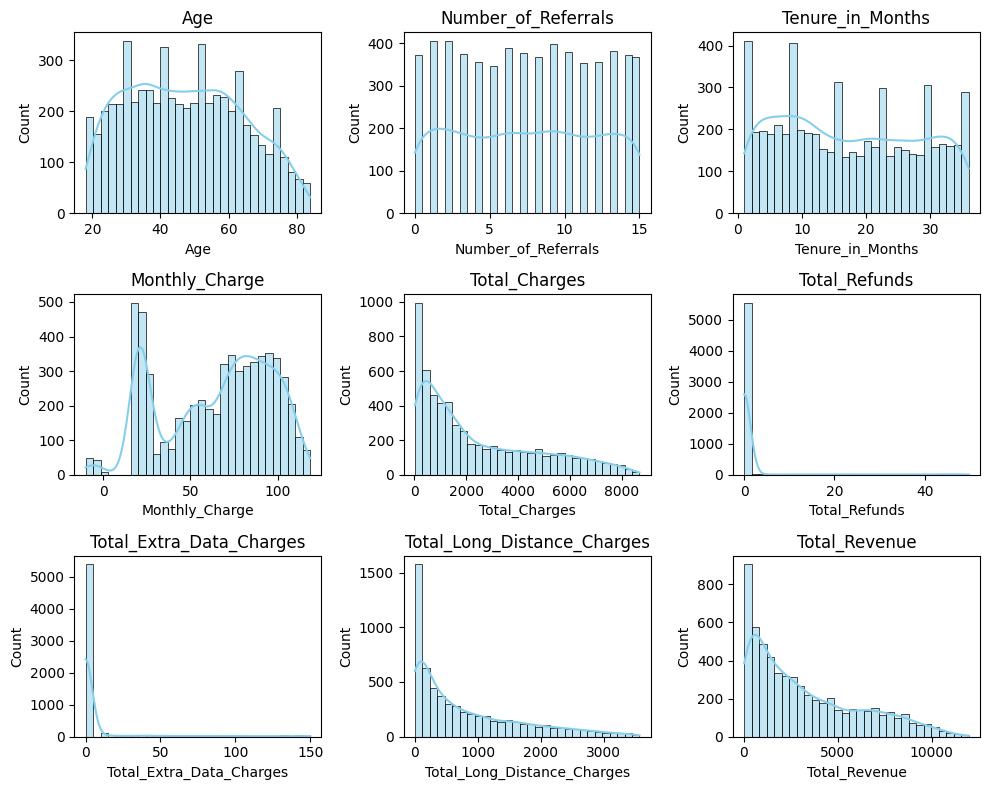

In [79]:
import math
cols_per_row = 3
rows = math.ceil(len(num_cols) / cols_per_row)
fig, axs = plt.subplots(rows, cols_per_row, figsize=(10, 8))
axs = axs.flatten() 

for i, col in enumerate(num_cols):
    sns.histplot(df_churn[col], kde=True, ax=axs[i], bins=30, color='skyblue')
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

**Insights :**

Most numeric features are not normally distributed:
- Total_Refunds, Total_Extra_Data_Charges, and Total_Long_Distance_Charges are highly right-skewed.
- Total_Revenue and Total_Charges are moderately right-skewed.
- Features like Age, Monthly_Charge, and Tenure_in_Months are roughly symmetric.
    
**Therefore,if there is any outliers, we should use the IQR method to handle outliers**

### Yeo-Johnson transformation for skewed features

In [80]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

# Columns to transform
yeo_columns = [
    'Total_Charges',
    'Total_Refunds',
    'Total_Extra_Data_Charges',
    'Total_Long_Distance_Charges',
    'Total_Revenue'
]

# Initialize transformer
pt = PowerTransformer(method='yeo-johnson')  

# Apply transformation only to selected columns
df_churn[yeo_columns] = pt.fit_transform(df_churn[yeo_columns])


### Outlier Detection (Boxplots)

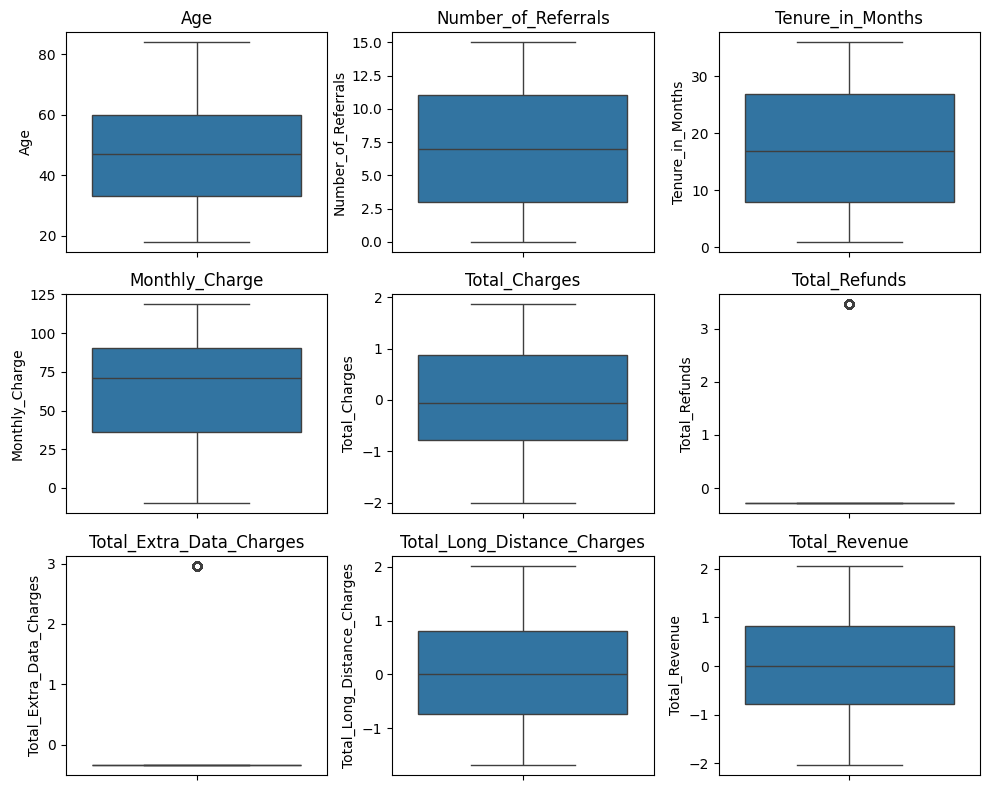

In [10]:
cols_per_row = 3
rows = math.ceil(len(num_cols) / cols_per_row)
fig, axs = plt.subplots(rows, cols_per_row, figsize=(10, 8))
axs = axs.flatten() 
for i, col in enumerate(num_cols):
    sns.boxplot(y=df_churn[col], ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

**Insights :**                                    
- Columns with significant outliers:
    - Total_Refunds
    - Total_Extra_Data_Charges

### Handling Outliers

In [11]:
#Step 1: Use IQR Method for Skewed Features
def iqr_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper
    
# Step 2: Cap Extreme Values
def cap_outliers(df, col):
    lower, upper = iqr_outliers(df, col)
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])
    return df

# Step 3: Apply to Skewed / Outlier-Prone Features
outlier_cols = ['Total_Extra_Data_Charges', 'Total_Revenue']

for col in outlier_cols:
    df_churn = cap_outliers(df_churn, col)

### Target Variable

In [12]:
df_churn['Customer_Status'] = df_churn['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

### Feature Selection & Encoding

In [41]:
# Drop irrelevant columns:
drop_cols = ['Customer_ID','Customer_Status','Churn_Category','Churn_Reason']
X = df_churn.drop(columns=drop_cols)
y = df_churn['Customer_Status']

In [42]:
# Label encoding for categorical features
cat_cols = X.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col].astype(str))

In [43]:
# Remove low variance features:
selector = VarianceThreshold(threshold=0.01)
selector.fit(X)
low_var_features = X.columns[~selector.get_support()]
X = X.drop(columns=low_var_features)
print("Dropped low-variance features:", list(low_var_features))

Dropped low-variance features: ['Total_Extra_Data_Charges']


### Train/Test Split

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### StandardScaler

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Transform test data
X_test_scaled = scaler.transform(X_test)

### Handle Imbalanced Data(SMOTE)

In [46]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res  = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE :", np.bincount(y_train_res))

Before SMOTE: [3420 1385]
After SMOTE : [3420 3420]


### Model Building (Random Forest)

In [47]:
rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=None,
    random_state=42
)

rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:,1]

### Model Evaluation

Best threshold (Youden's J): 0.435
Classification Report (Custom Threshold):
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       855
           1       0.70      0.76      0.73       347

    accuracy                           0.84      1202
   macro avg       0.80      0.82      0.81      1202
weighted avg       0.84      0.84      0.84      1202



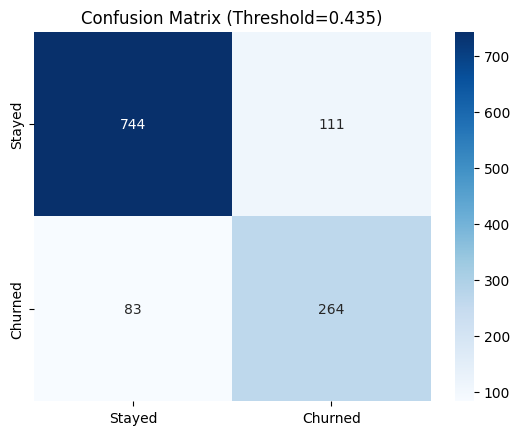

[[744 111]
 [ 83 264]]
ROC-AUC: 0.8939700355596002


In [48]:
# Get predicted probabilities for positive class
y_proba = rf.predict_proba(X_test_scaled)[:,1]
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Youden's J statistic
J = tpr - fpr
best_idx = np.argmax(J)
best_threshold = thresholds[best_idx]
print("Best threshold (Youden's J):", best_threshold)

# Apply custom threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

# Evaluate performance
print("Classification Report (Custom Threshold):")
print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Stayed","Churned"], yticklabels=["Stayed","Churned"])
plt.title(f"Confusion Matrix (Threshold={best_threshold:.3f})")
plt.show()
print(cm)
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

### Feature Importance (Business Insights)

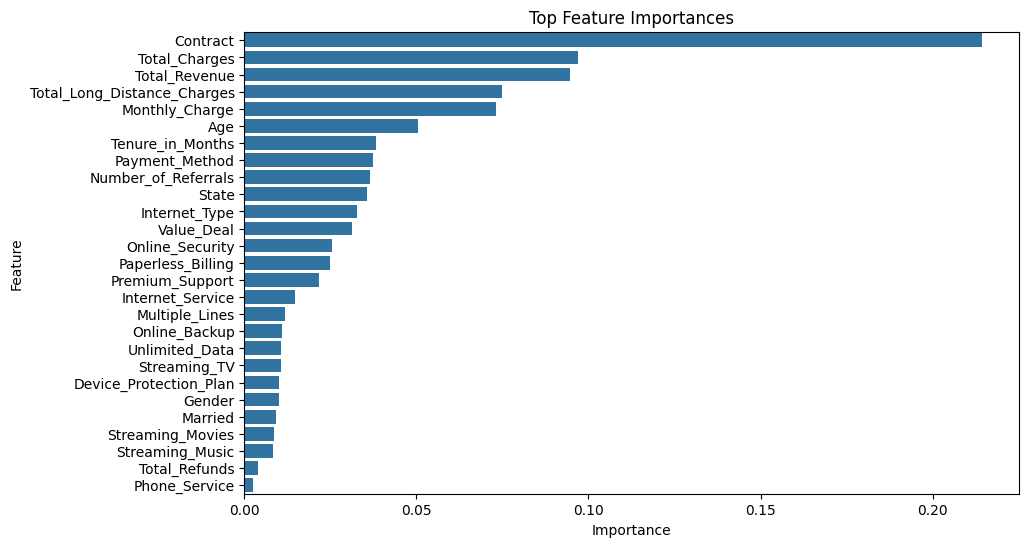

In [49]:
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Top Feature Importances")
plt.show()


### Rebuild the Model with important Features

In [50]:
top_features = feat_imp[feat_imp['Importance'] > 0.01]['Feature'].tolist()
X_top = X[top_features]

In [51]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, stratify=y, random_state=42
)

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE on Training Set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

### Random Forest Training & Evaluation

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       855
           1       0.67      0.79      0.72       347

    accuracy                           0.83      1202
   macro avg       0.79      0.82      0.80      1202
weighted avg       0.84      0.83      0.83      1202



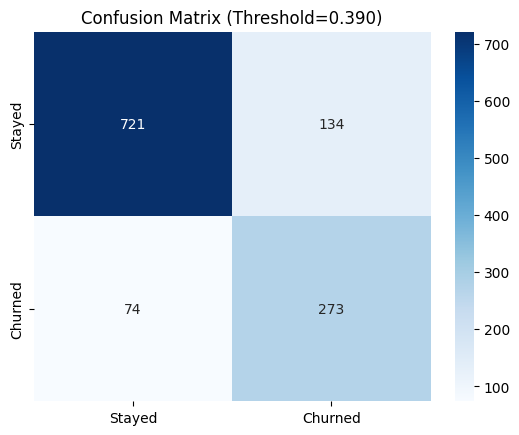

[[721 134]
 [ 74 273]]
ROC-AUC: 0.8951210880226503
Best threshold (Youden's J): 0.39


In [53]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_res, y_train_res)
y_proba = rf.predict_proba(X_test_scaled)[:,1]

# Use Youden's J to find best threshold
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
J = tpr - fpr
best_threshold = thresholds[np.argmax(J)]
y_pred_custom = (y_proba >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Stayed","Churned"], yticklabels=["Stayed","Churned"])
plt.title(f"Confusion Matrix (Threshold={best_threshold:.3f})")
plt.show()
print(cm)
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Best threshold (Youden's J):", best_threshold)


### Save Model Pipeline

In [54]:
joblib.dump(pt, "pt.pkl")                          # Yeo-Johnson transformer
joblib.dump(le, "label_encoder.pkl")               # LabelEncoder
joblib.dump(scaler, "scaler.pkl")                  # StandardScaler
joblib.dump(rf, "rf_model.pkl")                    # RandomForest model
joblib.dump(best_threshold, "best_threshold.pkl")  # Custom threshold
joblib.dump(top_features, "top_features.pkl")      # Final selected features

['top_features.pkl']

In [ ]:
# Load back
pt = joblib.load("pt.pkl")
le = joblib.load("label_encoder.pkl")
scaler = joblib.load("scaler.pkl")
rf = joblib.load("rf_model.pkl")
best_threshold = joblib.load("best_threshold.pkl")
top_features = joblib.load("top_features.pkl")

### Prediction on Join Dataset

In [46]:
# Load join data
df_join = pd.read_sql("SELECT * FROM dbo.vw_JoinData;", engine)
def predict_churn(df):
    df_join_copy = df.copy()
    # Apply Yeo-Johnson same transformations
    yeo_columns = ['Total_Charges','Total_Refunds','Total_Extra_Data_Charges',
                   'Total_Long_Distance_Charges','Total_Revenue']
    # Apply Yeo-Johnson transformation
    df_join_copy[yeo_columns] = pt.transform(df_join_copy[yeo_columns])
    # Keep only top features
    df_join_copy = df_join_copy[top_features]
    # Encode categoricals
    for col in df_join_copy.select_dtypes(include=['object']).columns:
        df_join_copy[col] = le.fit_transform(df_join_copy[col].astype(str)) 
    
    # Select only final trained features
    X_join = df_join_copy[top_features] # for prediction no need Customer_ID
    # Scale
    X_join_scaled = scaler.transform(X_join)
    
    # Predict
    df_churn_pred = df.copy()
    df_churn_pred['Churn_Probability'] = rf.predict_proba(X_join_scaled)[:,1]
    df_churn_pred['Prediction_Status'] = (df_churn_pred['Churn_Probability'] >= best_threshold).astype(int)
    df_churn_pred['Prediction_Status'] = df_churn_pred['Prediction_Status'].map({0: 'Stayed', 1: 'Churned'}) 
    return df_churn_pred

In [47]:
df_churn_pred = predict_churn(df_join)
df_churn_pred.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,Internet_Type,Online_Security,Online_Backup,Device_Protection_Plan,Premium_Support,Streaming_TV,Streaming_Movies,Streaming_Music,Unlimited_Data,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason,Churn_Probability,Prediction_Status
0,59750-AND,Female,49,Yes,Andhra Pradesh,11,4,None,Yes,Yes,Yes,Fiber Optic,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,74.900002,136.050003,0.0,0,82.160004,218.210007,Joined,Others,Others,0.345,Stayed
1,61025-MAH,Female,45,No,Maharashtra,4,16,Deal 5,Yes,No,Yes,DSL,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,49.849998,49.849998,0.0,0,42.549999,92.400002,Joined,Others,Others,0.190,Stayed
2,61203-PUN,Female,19,No,Punjab,11,11,None,Yes,Yes,Yes,Cable,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,No,Bank Withdrawal,64.599998,174.199997,0.0,0,122.970001,297.170013,Joined,Others,Others,0.205,Stayed
3,61331-UTT,Male,36,Yes,Uttarakhand,2,10,Deal 5,Yes,No,Yes,DSL,Yes,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,50.750000,50.750000,0.0,0,45.770000,96.519997,Joined,Others,Others,0.185,Stayed
4,61474-TEL,Male,52,Yes,Telangana,11,17,None,Yes,No,No,None,No,No,No,No,No,No,No,No,Month-to-Month,No,Credit Card,20.350000,20.350000,0.0,0,31.969999,52.320000,Joined,Others,Others,0.100,Stayed


## Save predictions back to SQL
We have now filtered only the predicted churned customers and saved the results to the SQL table ChurnPredictions.


In [48]:
# Filter only Churned customers
df_churned_pred = df_churn_pred[df_churn_pred['Prediction_Status']=='Churned']
df_churned_pred.to_sql("ChurnPredictions",   
    engine,
    if_exists="replace",   
    index=False)

-1

This table can now be imported into Power BI for Prediction Analysis.
Now we can move to Power BI Prediction Dashboard to interpret and present model results effectively.

###  END OF PROJECT
End-to-End Churn Prediction Pipeline Completed Successfully!